In [449]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats as st
import matplotlib.pyplot as plt
import random

In [450]:
df = pd.read_csv("Early_Exit_Confidence_data_imdb_2_exits(4,12)_difference.csv")
df.head(5)

,Unnamed: 0,Fou_layer_P,Last_layer,PProb_thi,PProb_las,True_labels
0,0,1,1,0.162018,0.325878,1
1,1,1,0,0.167257,0.210833,1
2,2,1,1,0.158408,0.367216,1
3,3,1,1,0.300808,0.193138,1
4,4,1,1,0.143136,0.061296,1


# One_UBERT_Cycle

In [451]:
def one_cycle(df):
    c_i_data = []
    for i in df["PProb_thi"]:
        c_i_data.append(i)
        
        
    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)
        
    number_of_actions = 10
    action_set = [0.10*(i+1) for i in range(number_of_actions)]
    
    
    def reward(c_i, c_l, action, overhead):
        if c_i >= action_set[action]:
            reward = 0
        else:
            reward = c_l - c_i - overhead
        return reward
    
    
    def next_action(Q, c_tilde, N, t):
      # Q is the list of rewards
      # c_tilde is the hyperparameter
      # N is the number of times an action is chosen
        next_a = []
        for i in range(len(action_set)):

            next_a.append(Q[i] + c_tilde*((np.log(t)/N[i])**(0.5)))

        return next_a.index(max(next_a))
    
    
    def update_parameters(Q, N, t, c_i_data, c_l_data, chosen_action, overhead):
        n = N[chosen_action]
        N[chosen_action] += 1
        Q[chosen_action] = (n*Q[chosen_action] + reward(c_i_data[t], c_l_data[t], chosen_action, overhead))/N[chosen_action]
        return Q, N
    
    

    def initialize(Q, N, action_set, c_i_data, c_l_data, overhead):
        for t in range(len(action_set)):
            update_parameters(Q, N, t, c_i_data, c_l_data, t, overhead)
        # print(N)
        return Q, N
    
    
    
    
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data[t] >= i:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(0.1)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    
    def one_UCB_cycle(Q, N, c_tilde, c_i_data, c_l_data, overhead, df):
        action_chosen = []
        predictions = []
        rewards = []
        for t in range(df.shape[0]):
            if t < len(action_set):
                pass
            else:

                action = next_action(Q, c_tilde, N, t)
                # print(action)
                action_chosen.append(action)
                if c_i_data[t] >= action_set[action]:
                    reward = 0
                    predictions.append(df["Fou_layer_P"][t])
                    rewards.append(reward)
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                    predictions.append(df["Last_layer"][t])
                    rewards.append(reward)
                Q, N = update_parameters(Q, N, t, c_i_data, c_l_data, action, overhead)

        return action_chosen, predictions, rewards, Q, N
    
    
    Q = [0 for i in range(len(action_set))]
    N = [0 for i in range(len(action_set))]
    c_tilde = 2
    overhead = 0.1
    Q, N = initialize(Q, N, action_set, c_i_data, c_l_data, overhead)
    action, preds, rewards, Q, N = one_UCB_cycle(Q, N, c_tilde, c_i_data, c_l_data, overhead , df)
    
    optimal_action = Q.index(max(Q))
    print("Optimal_action is ", optimal_action)
    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        if i < len(action_set):
            if c_i_data[i] > action_set[oracle_action]:
    #             reward = 0
                count += 1
                preds.append(df["Fou_layer_P"][i])
    #             optimal_reward.append(reward)
            else:
                preds.append(df["Last_layer"][i])
    #             reward = c_l_data[i] - c_i_data[i] - overhead
    #             optimal_reward.append(reward)
        else:
            if c_i_data[i] > action_set[oracle_action]:
                reward = 0
                count += 1
                preds.append(df["Fou_layer_P"][i])
                oracle_reward.append(reward)
            else:
                preds.append(df["Last_layer"][i])
                reward = c_l_data[i] - c_i_data[i] - overhead
                oracle_reward.append(reward)
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    
    
    return cumulative_regret

In [452]:
one_cycle(df)

Oracle action =====>  1
Optimal_action is  1


array([  0.        ,   0.        ,   0.        , ..., 523.67789198,
       523.67789198, 523.67789198])

In [453]:
num_cycles = 5
reg_lis = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg = one_cycle(df)
    if i%50 == 0:
        
        reg_lis.append(cum_reg)
    
reg_lis = np.array(reg_lis)

Oracle action =====>  1
Optimal_action is  1
Oracle action =====>  1
Optimal_action is  1
Oracle action =====>  1
Optimal_action is  0
Oracle action =====>  1
Optimal_action is  1
Oracle action =====>  1
Optimal_action is  1


In [454]:
number_of_actions = 10
action_set = [0.10*(i+1) for i in range(number_of_actions)]

In [455]:
reg_lis.mean(axis=0).shape

(24990,)

In [456]:
lower = []
upper = []

for i in range(df.shape[0]-len(action_set)):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis[:,i])-1,
              loc=np.mean(reg_lis[:,i]),
              scale=st.sem(reg_lis[:,i]))
    if i%50 == 0:
        
        lower.append(intrval[0])
        upper.append(intrval[1])

C:\Users\divya\anaconda3\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\divya\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Other-Exit

In [457]:
def one_action_cycle(df, action):
    c_i_data = []
    for i in df["PProb_thi"]:
        c_i_data.append(i)
        
#     random.seed(9)    
    c_l_data = []
    for i in df["PProb_las"]:
        c_l_data.append(i)
        
    number_of_actions = 10
    action_set = [0.10*(i+1) for i in range(number_of_actions)]
    overhead = 0.1  
    
 
    def oracle_action(overhead):
        oracle_reward = []
        for i in action_set:
            o_reward = 0 
            for t in range(df.shape[0]):
                if c_i_data[t] >= i:
                    reward = 0
    #                 predictions.append(df["Fou_layer_P"][t])
                else:
                    reward = c_l_data[t] - c_i_data[t] - overhead
                o_reward += reward
    #         print(oracle_reward)
            oracle_reward.append(o_reward/df.shape[0])

        return oracle_reward.index(max(oracle_reward)), oracle_reward
    oracle_action, o_reward = oracle_action(0.1)
    
    
    print("Oracle action =====> ", oracle_action)
    
    
    preds = []
    count = 0
    oracle_reward = []
    for i in range(df.shape[0]):
        if i < len(action_set):
            if c_i_data[i] >= action_set[oracle_action]:
    #             reward = 0
                count += 1
                preds.append(df["Fou_layer_P"][i])
    #             optimal_reward.append(reward)
            else:
                preds.append(df["Last_layer"][i])
    #             reward = c_l_data[i] - c_i_data[i] - overhead
    #             optimal_reward.append(reward)
        else:
            if c_i_data[i] > action_set[oracle_action]:
                reward = 0
                count += 1
                preds.append(df["Fou_layer_P"][i])
                oracle_reward.append(reward)
            else:
                preds.append(df["Last_layer"][i])
                reward = c_l_data[i] - c_i_data[i] - overhead
                oracle_reward.append(reward)
    
    
#     action = random.choice(action_set)
    print("Action is ", action)
    
    
    
     
    
    
    
    
#     preds = []
#     count_1 = 0
    rewards = []
    for i in range(df.shape[0]):
        if i < len(action_set):
            if c_i_data[i] >= action:
    #             reward = 0
#                 count_1 += 1
                preds.append(df["Fou_layer_P"][i])
    #             optimal_reward.append(reward)
            else:
                preds.append(df["Last_layer"][i])
    #             reward = c_l_data[i] - c_i_data[i] - overhead
    #             optimal_reward.append(reward)
        else:
            if c_i_data[i] >= action:
                reward = 0
#                 count_1 += 1
                preds.append(df["Fou_layer_P"][i])
                rewards.append(reward)
            else:
                preds.append(df["Last_layer"][i])
                reward = c_l_data[i] - c_i_data[i] - overhead
                rewards.append(reward)
    
                
    oracle_reward = np.array(oracle_reward)
    rewards = np.array(rewards)
    regret = (oracle_reward-rewards)
    cumulative_regret = abs(np.cumsum(regret))
    
    
    return cumulative_regret

In [440]:
reg_lis_3 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_3 = one_action_cycle(df, 0.3)
    if i%50 == 0:
        
        reg_lis_3.append(cum_reg_3)
    
reg_lis_3 = np.array(reg_lis_3)

Oracle action =====>  1
Action is  0.3
Oracle action =====>  1
Action is  0.3
Oracle action =====>  1
Action is  0.3
Oracle action =====>  1
Action is  0.3
Oracle action =====>  1
Action is  0.3


In [441]:
lower_3 = []
upper_3 = []

for i in range(df.shape[0]-len(action_set)):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_3[:,i])-1,
              loc=np.mean(reg_lis_3[:,i]),
              scale=st.sem(reg_lis_3[:,i]))
    if i%50 == 0:
        
        lower_3.append(intrval[0])
        upper_3.append(intrval[1])

# $\alpha = 0.4$

In [442]:
reg_lis_4 = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_4 = one_action_cycle(df, 0.4)
    if i%50 == 0:
        
        reg_lis_4.append(cum_reg_4)
    
reg_lis_4 = np.array(reg_lis_4)

Oracle action =====>  1
Action is  0.4
Oracle action =====>  1
Action is  0.4
Oracle action =====>  1
Action is  0.4
Oracle action =====>  1
Action is  0.4
Oracle action =====>  1
Action is  0.4


In [443]:
lower_4 = []
upper_4 = []

for i in range(df.shape[0]-len(action_set)):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_4[:,i])-1,
              loc=np.mean(reg_lis_4[:,i]),
              scale=st.sem(reg_lis_4[:,i]))
    if i % 50 == 0:
        
        lower_4.append(intrval[0])
        upper_4.append(intrval[1])

# $Early-Exit$  

In [444]:
reg_lis_5 = []
for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_5 = one_action_cycle(df, 0.0)
    if i%50 == 0:
        
        reg_lis_5.append(cum_reg_5)
    
reg_lis_5 = np.array(reg_lis_5)

Oracle action =====>  1
Action is  0.0
Oracle action =====>  1
Action is  0.0
Oracle action =====>  1
Action is  0.0
Oracle action =====>  1
Action is  0.0
Oracle action =====>  1
Action is  0.0


In [445]:
lower_5 = []
upper_5 = []

for i in range(df.shape[0]-len(action_set)):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_5[:,i])-1,
              loc=np.mean(reg_lis_5[:,i]),
              scale=st.sem(reg_lis_5[:,i]))
    if i%50==0:
        
        lower_5.append(intrval[0])
        upper_5.append(intrval[1])

# Final-Exit 

In [446]:
reg_lis_fin = []

for i in range(num_cycles):
    df = df.sample(frac = 1)
    cum_reg_fin = one_action_cycle(df, action_set[-1])
    if i %50 == 0:
        
        reg_lis_fin.append(cum_reg_fin)
    
reg_lis_fin = np.array(reg_lis_fin)

Oracle action =====>  1
Action is  1.0
Oracle action =====>  1
Action is  1.0
Oracle action =====>  1
Action is  1.0
Oracle action =====>  1
Action is  1.0
Oracle action =====>  1
Action is  1.0


In [447]:
lower_fin = []
upper_fin = []

for i in range(df.shape[0]-len(action_set)):
    intrval = st.t.interval(alpha=0.95, df=len(reg_lis_fin[:,i])-1,
              loc=np.mean(reg_lis_fin[:,i]),
              scale=st.sem(reg_lis_fin[:,i]))
    if i%50 == 0:
        
        lower_fin.append(intrval[0])
        upper_fin.append(intrval[1])

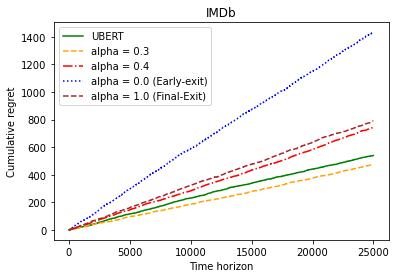

In [448]:
x = [i for i in range(len(lower))]
plt.plot(reg_lis.mean(axis = 0) ,'g', label="UBERT",linestyle = 'solid')
plt.fill_between(x, lower, upper, color='green', alpha=0.1)
plt.plot(reg_lis_3.mean(axis = 0) ,'orange', label="alpha = 0.3", linestyle = 'dashed')
plt.fill_between(x, lower_3, upper_3, color='orange', alpha=0.1)
plt.plot(reg_lis_4.mean(axis = 0) ,'red', label="alpha = 0.4", linestyle = 'dashdot')
plt.fill_between(x, lower_4, upper_4, color='red', alpha=0.1)
plt.plot(reg_lis_5.mean(axis = 0) ,'blue', label="alpha = 0.0 (Early-exit)",linestyle = 'dotted')
plt.fill_between(x, lower_5, upper_5, color='blue', alpha=0.1)
plt.plot(reg_lis_fin.mean(axis = 0) ,'brown', label="alpha = 1.0 (Final-Exit)",linestyle = 'dashed')
plt.fill_between(x, lower_fin, upper_fin, color='brown', alpha=0.1)
plt.legend()
plt.xlabel("Time horizon")
plt.ylabel("Cumulative regret")
plt.title("IMDb")
plt.savefig('CI imdb regret 4th_new.pdf')
plt.show()